In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from matplotlib import pyplot as plt
from pandas import read_excel, melt
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind, shapiro
from pandas import pivot_table

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway # 등분산이 아닐 때: welch 검정

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import anova, welch_anova, pairwise_gameshowell, pairwise_tukey

# 연습문제 (ANOVA)

## 문제 1

다음은 소나무 품종별 무게를 조사한 데이터이다.

분석하라.


| A    | B    | C    |
|------|------|------|
| 4.17 | 4.81 | 6.31 |
| 5.58 | 4.17 | 5.12 |
| 5.18 | 4.41 | 5.54 |
| 6.11 | 3.59 | 5.5  |
| 4.5  | 5.87 | 5.37 |
| 4.61 | 3.83 | 5.29 |
| 5.17 | 6.03 | 4.92 |
| 4.53 | 4.89 | 6.15 |
| 5.33 | 4.32 | 5.8  |
| 5.14 | 4.69 | 5.26 |

> https://data.hossam.kr/mldata/tree_weight.xlsx


In [2]:
origin = read_excel("https://data.hossam.kr/mldata/tree_weight.xlsx")
origin.head()

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


In [3]:
plt.rcParams["font.family"]='Malgun Gothic'
plt.rcParams["font.size"] =12
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.unicode_minus'] = False

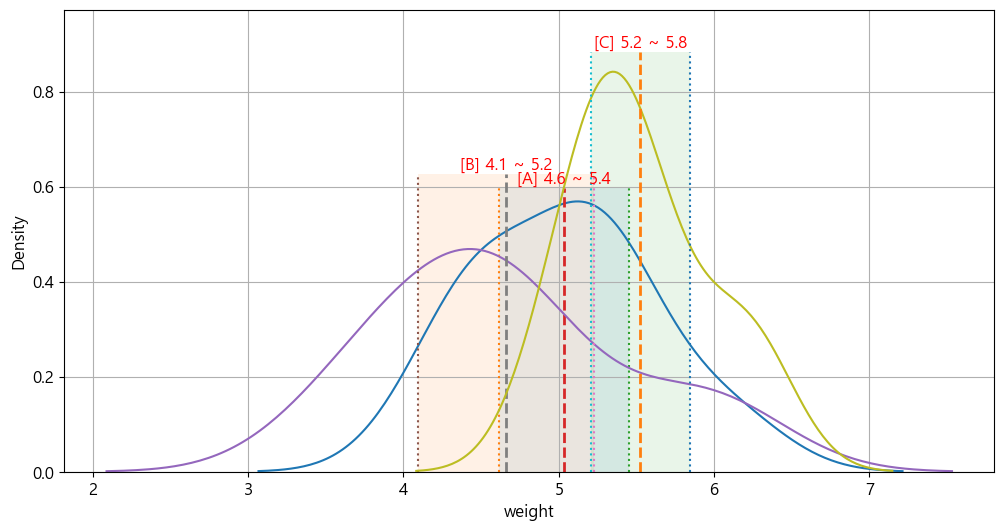

In [4]:
plt.figure()

for values in origin['group'].unique():
    #print(c)

    data = origin[origin['group'] == values]['weight']
                          # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (values, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [5]:
for values in origin['group'].unique():
    s, p = normaltest(origin[origin['group'] == values]['weight'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(origin[origin['group'] == values]['weight'], s, p, p > 0.05))
    normal_dist = p>0.05      # 정규성 만족 여부
      # 원본 데이터 복사
    fields = list(origin[origin['group'] == values]['weight'])
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*fields)
    else:
        n = "Levene"
        s, p = levene(*fields)

    print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[0    4.17
1    5.58
2    5.18
3    6.11
4    4.50
5    4.61
6    5.17
7    4.53
8    5.33
9    5.14
Name: weight, dtype: float64] statistic: 0.233, p-value: 0.890, 정규성 충족 여부: True
Bartlett 검정: statistic: nan, p-value: nan, 등분산성 충족 여부: False
[10    4.81
11    4.17
12    4.41
13    3.59
14    5.87
15    3.83
16    6.03
17    4.89
18    4.32
19    4.69
Name: weight, dtype: float64] statistic: 0.968, p-value: 0.616, 정규성 충족 여부: True
Bartlett 검정: statistic: nan, p-value: nan, 등분산성 충족 여부: False
[20    6.31
21    5.12
22    5.54
23    5.50
24    5.37
25    5.29
26    4.92
27    6.15
28    5.80
29    5.26
Name: weight, dtype: float64] statistic: 1.013, p-value: 0.603, 정규성 충족 여부: True
Bartlett 검정: statistic: nan, p-value: nan, 등분산성 충족 여부: False


In [6]:
lm = ols('weight ~ C(group)', data=origin).fit()
anova = anova_lm(lm, robust='hc3')
print(anova)
s = anova['F'][0]
p = anova['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

            df    sum_sq   mean_sq         F   PR(>F)
C(group)   2.0   3.76634  1.883170  4.846088  0.01591
Residual  27.0  10.49209  0.388596       NaN      NaN


'statistic: 4.846, p-value: 0.016, 대립가설 채택'

In [7]:
comp = MultiComparison(origin['weight'], origin['group'])
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
A,B,1.1913,0.249,0.7471,False
A,C,-2.134,0.0469,0.1406,False
B,C,-3.0101,0.0075,0.0226,True


## 문제 2

다음은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터의 일부이다.

| time | poison | treat |
|------|--------|-------|
| 0.31 | 1      | A     |
| 0.45 | 1      | A     |
| 0.46 | 1      | A     |
| 0.43 | 1      | A     |
| 0.36 | 2      | A     |


> https://data.hossam.kr/mldata/poisons.xlsx

데이터의 각 변수는 다음과 같다.

| 필드 | 설명 |
|--|--|
| Time | 동물의 생존시간 |
| poison | 사용된 독극물 종류 |
| treat | 사용되는 치료 유형 |

사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.


In [52]:
origin = read_excel("https://data.hossam.kr/mldata/poisons.xlsx")
origin.head()

,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1


### [1] 독극물의 치료약 별 해독시간

In [ ]:
fields = ['P1', 'P2', 'P3']

fig, ax = plt.subplots(3, 1, figsize=(12, 15), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v, in enumerate(ax):
    sb.kdeplot(data=origin[origin['poison']== fields[i]], x=origin[origin['poison']== fields[i]]['time'], hue='treat', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title("%s의 치료약 별 치료시간" % fields[i])

txt = "치료시간이 치료약에 따라 다른 분포를 보이는 것을 확인할 수 있다."
plt.figtext(0.51, 0.07, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

### [3] 독극물별 해독시간

In [ ]:
fields = ['T1', 'T2', 'T3', 'T4']

fig, ax = plt.subplots(4, 1, figsize=(12, 15), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v, in enumerate(ax):
    sb.kdeplot(data=origin[origin['treat']== fields[i]], x=origin[origin['treat']== fields[i]]['time'], hue='poison', palette='Set2',
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title("%s의 독극물 별 치료시간" % fields[i])

txt = "치료시간이 독극물에 따라 다른 분포를 보이는 것을 확인할 수 있다."
plt.figtext(0.51, 0.07, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

### [3] 분산분석의 가정 확인

#### (1) 정규성과 등분산성


In [59]:
treat = origin['treat'].unique()
poison = origin['poison'].unique()
print(treat, poison)

['T1' 'T2' 'T3' 'T4'] ['P1' 'P2' 'P3']


In [68]:
normal_dist = True
treat = origin['treat'].unique()
poison = origin['poison'].unique()
for i, v in enumerate(treat):
    for j, k in enumerate(poison):
        s, p = normaltest(origin[(origin['treat']==v) & (origin['poison']==k)]['time'])
        print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format((v,k), s, p, p > 0.05))
        normal_dist = normal_dist and p>0.05
   # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: origin[origin['treat']==v]['time'], treat))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[('T1', 'P1')] statistic: 3.661, p-value: 0.160, 정규성 충족 여부: True
[('T1', 'P2')] statistic: 1.112, p-value: 0.573, 정규성 충족 여부: True
[('T1', 'P3')] statistic: 0.837, p-value: 0.658, 정규성 충족 여부: True
[('T2', 'P1')] statistic: 0.266, p-value: 0.875, 정규성 충족 여부: True
[('T2', 'P2')] statistic: 1.510, p-value: 0.470, 정규성 충족 여부: True
[('T2', 'P3')] statistic: 3.667, p-value: 0.160, 정규성 충족 여부: True
[('T3', 'P1')] statistic: 0.014, p-value: 0.993, 정규성 충족 여부: True
[('T3', 'P2')] statistic: 2.802, p-value: 0.246, 정규성 충족 여부: True
[('T3', 'P3')] statistic: 0.425, p-value: 0.809, 정규성 충족 여부: True
[('T4', 'P1')] statistic: 1.476, p-value: 0.478, 정규성 충족 여부: True
[('T4', 'P2')] statistic: 1.662, p-value: 0.436, 정규성 충족 여부: True
[('T4', 'P3')] statistic: 0.164, p-value: 0.921, 정규성 충족 여부: True
Bartlett 검정: statistic: 0.000, p-value: 1.000, 등분산성 충족 여부: True


In [69]:
formula = 'time ~ C(treat)*C(poison)'
lm = ols(formula, origin).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(treat),3.0,131.260972,43.753657,43.891090,4.430485e-24
C(poison),2.0,148.976389,74.488194,74.722166,1.002877e-27
C(treat):C(poison),6.0,81.381611,13.563602,13.606206,6.938981e-14
Residual,348.0,346.910333,0.996869,NaN,NaN


> 치료제 대한 p값은 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.
>
> 독에 대한 p값 역시 0.05보다 작으므로 통계적으로 유의한 차이를 보인다고 할 수 있다.
>
> 또한 치료제와 독에 대한 p값은 0.05보다 작기 때문에 치료제와 독에는 교호관계가 있다고 할 수 있다.

## 문제 3

효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지 실험연구를 하여 다음 자료를 얻었다.

분산분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는지 검정하라.

<table>
    <tr>
        <th>효소함량</th>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
    </tr>
    <tr>
        <th>모종성장</th>
        <td>10.8</td>
        <td>9.1</td>
        <td>13.5</td>
        <td>9.2</td>
        <td>11.1</td>
        <td>11.2</td>
        <td>8.2</td>
        <td>11.3</td>
        <td>5.4</td>
        <td>4.6</td>
        <td>7.4</td>
        <td>5</td>
        <td>5.8</td>
        <td>5.3</td>
        <td>3.2</td>
        <td>7.5</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/tomato.xlsx

In [70]:
origin = read_excel("https://data.hossam.kr/mldata/tomato.xlsx")
origin.head()

,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4


In [ ]:
values = origin['효소함량'].unique()
unique_values

array([    0,  1000,  5000, 10000], dtype=int64)

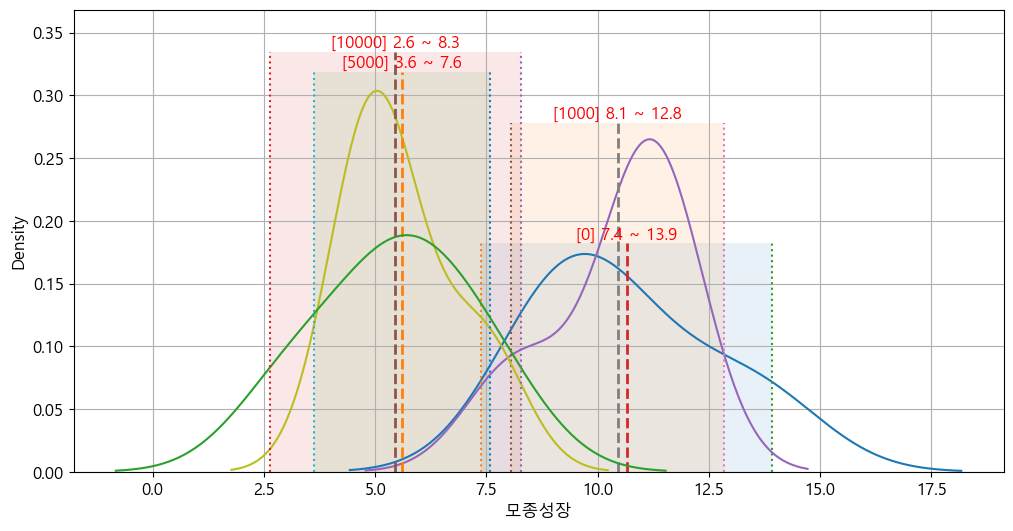

In [ ]:
plt.figure()

for values in origin['효소함량'].unique():
    #print(c)

    data = origin[origin['효소함량'] == values]['모종성장']                               # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (values, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [ ]:
from scipy.stats import shapiro, skew, kurtosis, normaltest, bartlett, levene

In [ ]:
normal_dist = True
for values in origin['효소함량'].unique():
    s, p = shapiro(origin[origin['효소함량'] == values]['모종성장'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    normal_dist = normal_dist and p>0.05
   # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: origin[origin['효소함량'] == x]['모종성장'], origin['효소함량'].unique()))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[모종성장] statistic: 0.856, p-value: 0.245, 정규성 충족 여부: True
[모종성장] statistic: 0.681, p-value: 0.007, 정규성 충족 여부: False
[모종성장] statistic: 0.854, p-value: 0.240, 정규성 충족 여부: True
[모종성장] statistic: 0.981, p-value: 0.908, 정규성 충족 여부: True
Levene 검정: statistic: 0.310, p-value: 0.818, 등분산성 충족 여부: True


### [3] 사후검정

In [ ]:
tukey = pairwise_tukeyhsd(origin['모종성장'],origin['효소함량'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1000,-0.2,0.9982,-3.706,3.306,False
0,5000,-5.05,0.0051,-8.556,-1.544,True
0,10000,-5.2,0.0041,-8.706,-1.694,True
1000,5000,-4.85,0.0069,-8.356,-1.344,True
1000,10000,-5.0,0.0055,-8.506,-1.494,True
5000,10000,-0.15,0.9992,-3.656,3.356,False


## 문제 4

유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 다음과 같은 독서평가 점수자료를 얻었다.

세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

<table>
    <tr>
        <th>독서방법</th>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
    </tr>
    <tr>
        <th>점수</th>
        <td>6</td>
        <td>9</td>
        <td>2</td>
        <td>16</td>
        <td>7</td>
        <td>7</td>
        <td>12</td>
        <td>10</td>
        <td>16</td>
        <td>11</td>
        <td>7</td>
        <td>4</td>
        <td>7</td>
        <td>7</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/reading.xlsx


In [33]:
origin = read_excel("https://data.hossam.kr/mldata/reading.xlsx")
origin.head()

,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3


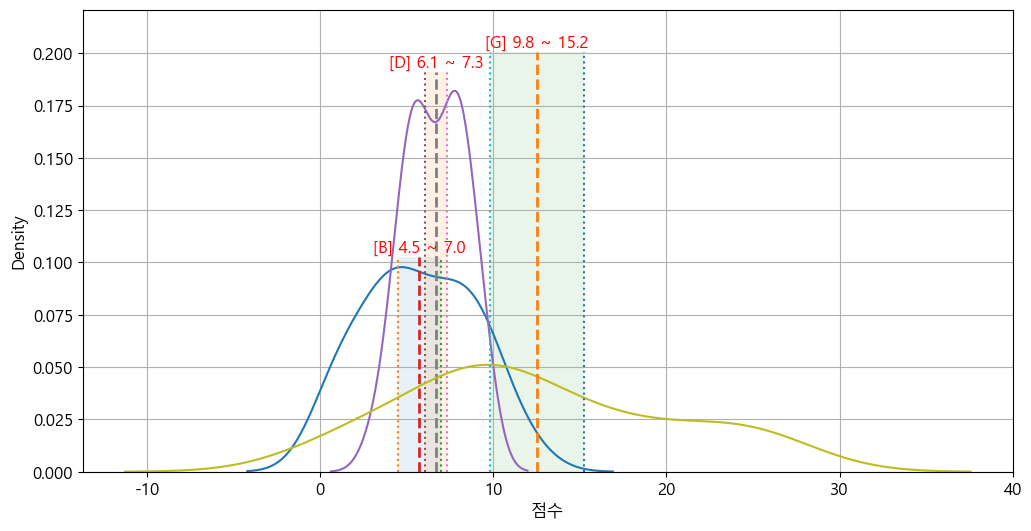

In [34]:
plt.figure()

for values in origin['독서방법'].unique():
    #print(c)

    data = origin[origin['독서방법']== values]['점수']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (values, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [22]:
origin['독서방법'] = origin['독서방법'].map(lambda x: str(x))
origin['독서방법']

0     B
1     B
2     B
3     B
4     B
     ..
85    G
86    G
87    G
88    G
89    G
Name: 독서방법, Length: 90, dtype: object

In [35]:
normal_dist = True
for values in origin['독서방법'].unique():
    s, p = shapiro(origin[origin['독서방법'] == values]['점수'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(values, s, p, p > 0.05))
    normal_dist = normal_dist and p>0.05
   # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: origin[origin['독서방법'] == x]['점수'], origin['독서방법']))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[B] statistic: 0.964, p-value: 0.432, 정규성 충족 여부: True
[D] statistic: 0.962, p-value: 0.343, 정규성 충족 여부: True
[G] statistic: 0.946, p-value: 0.113, 정규성 충족 여부: True
Bartlett 검정: statistic: 1761.325, p-value: 0.000, 등분산성 충족 여부: False


In [37]:
comp = MultiComparison(origin['점수'],origin['독서방법'])   # 독립변수, 명목형 순서대로 써 줘야함.
result = comp.allpairtest(ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
B,D,-1.4487,0.153,0.459,False
B,G,-4.4514,0.0,0.0001,True
D,G,-4.1589,0.0001,0.0003,True


## 문제 5

두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적이 다음과 같다.

이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지 검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요합니다.)

<table>
    <tr>
        <th>교육방법</th>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
    </tr>
    <tr>
        <th>국어</th>
        <td>65</td>
        <td>87</td>
        <td>73</td>
        <td>79</td>
        <td>81</td>
        <td>69</td>
        <td>55</td>
        <td>76</td>
        <td>77</td>
        <td>70</td>
        <td>88</td>
        <td>75</td>
        <td>69</td>
        <td>83</td>
        <td>81</td>
        <td>72</td>
        <td>79</td>
        <td>85</td>
        <td>89</td>
        <td>90</td>
        <td>77</td>
        <td>95</td>
    </tr>
    <tr>
        <th>영어</th>
        <td>82</td>
        <td>79</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>70</td>
        <td>79</td>
        <td>80</td>
        <td>76</td>
        <td>90</td>
        <td>68</td>
        <td>72</td>
        <td>75</td>
        <td>93</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>88</td>
        <td>92</td>
        <td>83</td>
        <td>93</td>
        <td>78</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/edu.xlsx


In [ ]:
origin = read_excel("https://data.hossam.kr/mldata/edu.xlsx")
origin.head()

,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65


In [ ]:
plt.rcParams["font.family"]='Malgun Gothic'
plt.rcParams["font.size"] =12
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
origin['교육방법'] = origin['교육방법'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   교육방법    22 non-null     category
 1   국어      22 non-null     int64   
 2   영어      22 non-null     int64   
dtypes: category(1), int64(2)
memory usage: 630.0 bytes


In [ ]:
origin[origin['교육방법']== 2]['국어'].count()

11

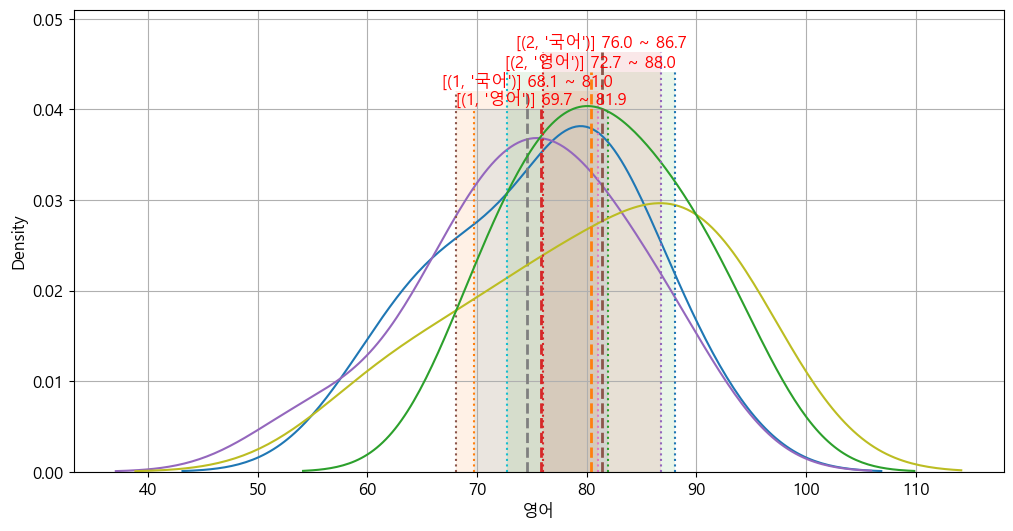

In [ ]:
plt.figure()

for values in origin['교육방법'].unique():
    #print(c)
    for i, v in enumerate(['영어', '국어']):
        data = origin[origin['교육방법'] == values][v]                                # 데이터만 추출
        max = data.max()                                # 최대값
        clevel = 0.95                                   # 신뢰수준
        dof = len(data) - 1                             # 자유도
        sample_mean = data.mean()                       # 표본평균
        sample_std = data.std(ddof=1)                   # 표본표준편차
        sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

        # 신뢰구간
        cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

        sb.kdeplot(data=data)

        xmin, xmax, ymin, ymax = plt.axis()

        # 신뢰구간 그리기
        plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
        plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
        plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

        # 평균 그리기
        plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

        plt.text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % ((values, v), cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, ymax*1.1)

plt.grid()
plt.show()
plt.close()

In [ ]:
normal_dist = True
for i, v in enumerate(['영어','국어']):
    for values in origin['교육방법'].unique():
        s, p = shapiro(origin[origin['교육방법']==values][v])
        print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format([v,values], s, p, p > 0.05))
        normal_dist = normal_dist and p>0.05
   # 정규성 만족 여부
    data = origin.copy()    # 원본 데이터 복사
    fields = list(map(lambda x: origin[origin['교육방법']== x][v], data['교육방법']))

    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*fields)
    else:
        n = "Levene"
        s, p = levene(*fields)

    print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[['영어', 1]] statistic: 0.968, p-value: 0.866, 정규성 충족 여부: True
[['영어', 2]] statistic: 0.925, p-value: 0.364, 정규성 충족 여부: True
Bartlett 검정: statistic: 5.424, p-value: 1.000, 등분산성 충족 여부: True
[['국어', 1]] statistic: 0.968, p-value: 0.870, 정규성 충족 여부: True
[['국어', 2]] statistic: 0.985, p-value: 0.987, 정규성 충족 여부: True
Bartlett 검정: statistic: 3.731, p-value: 1.000, 등분산성 충족 여부: True


In [ ]:
for i, v in enumerate(['영어','국어']):
    s, p = f_oneway(origin[v], origin['교육방법'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, {3}가설 채택".format(v, s, p, "대립" if p <= 0.05 else "귀무"))

[영어] statistic: 1210.265, p-value: 0.000, 대립가설 채택
[국어] statistic: 1472.115, p-value: 0.000, 대립가설 채택


In [ ]:
for i, v in enumerate(['영어','국어']):
    tukey = pairwise_tukeyhsd(origin[v], origin['교육방법'])
    print(v, tukey.summary())

영어 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   4.5455 0.3129 -4.6125 13.7034  False
----------------------------------------------------
국어 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   6.8182 0.0865 -1.0706 14.707  False
---------------------------------------------------


## 문제 6

서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.

주어진 데이터는 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.

> https://data.hossam.kr/mldata/commercial.xlsx

### 1) 상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.

### 2) 상권 종류별로 2023년 분기별 평균 매출액은 어떤 차이가 보이는지 분석하라.

In [38]:
origin = read_excel("https://data.hossam.kr/mldata/commercial.xlsx")
origin.head()

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


### [1] 상권 종류별 2023년 한 해 동안 평균 매출액 비교

In [39]:
origin['sales_amount'] =origin['sales_amount']*(1e-9)
origin

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72.523644,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283.332346,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81.696730,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212.062657,4960006
4,1,3001495,관광특구,잠실 관광특구,231.338387,5995166
...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13.523478,535132
6218,4,3130324,전통시장,길동복조리시장,6.236556,330148
6219,4,3130325,전통시장,명일전통시장,3.973269,186049
6220,4,3130326,전통시장,고덕 골목형상점가,15.013908,755565


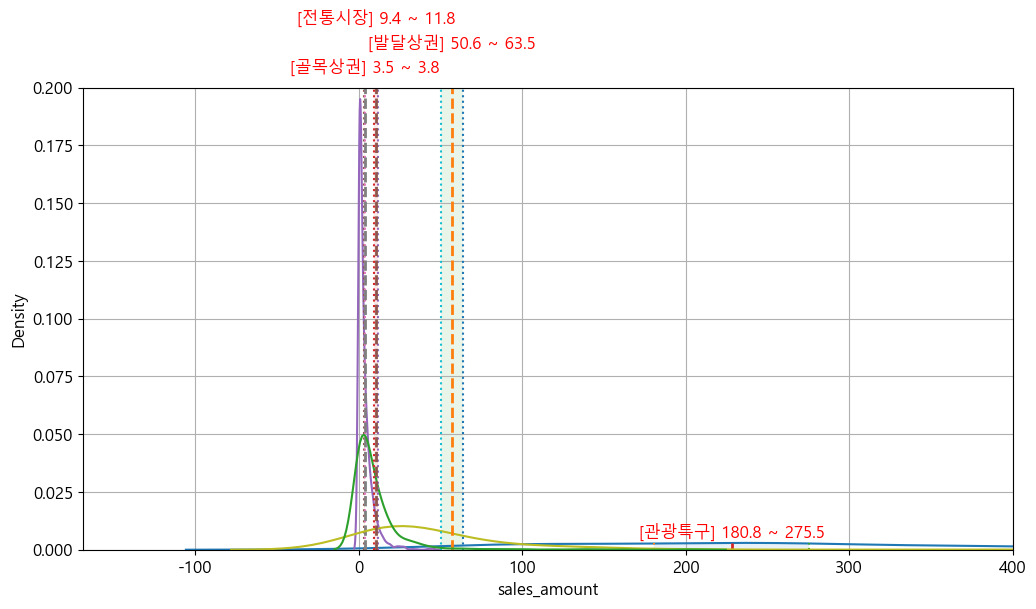

In [40]:
plt.figure()

for values in origin['type'].unique():
    #print(c)

    data = origin[origin['type']== values]['sales_amount']                                # 데이터만 추출
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차

    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=0, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (values, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(ymin, 0.2)
plt.xlim(xmin, 400)
plt.grid()
plt.show()
plt.close()

In [41]:
normal_dist = True
for values in origin['type'].unique():
    s, p = normaltest(origin[origin['type']==values]['sales_amount'])
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(values, s, p, p > 0.05))
    normal_dist = normal_dist and p>0.05
   # 정규성 만족 여부
data = origin.copy()    # 원본 데이터 복사
fields = list(map(lambda x: origin[origin['type']==x]['sales_amount'], values))

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)

print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))


[관광특구] statistic: 2.023, p-value: 0.364, 정규성 충족 여부: True
[골목상권] statistic: 2949.769, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 1174.364, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 1194.780, p-value: 0.000, 정규성 충족 여부: False
Levene 검정: statistic: nan, p-value: nan, 등분산성 충족 여부: False


> 등분산성을 충족하지 않을 경우, 
> 독립표본ttest의 welch-검정을 통해 평균 비교 후,
> gameswell 방법으로 사후검정한다.

In [42]:
s, p = f_oneway(origin[origin['type']=='관광특구']['sales_amount'],
                 origin[origin['type']=='골목상권']['sales_amount'],
                 origin[origin['type']=='발달상권']['sales_amount'],
                 origin[origin['type']=='전통시장']['sales_amount'])
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 612.137, p-value: 0.000, 대립가설 채택'

In [43]:
result = pairwise_gameshowell(origin, dv='sales_amount', between='type')
result

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,골목상권,관광특구,3.659509,228.143191,-224.483682,22.892160,-9.806138,23.000501,6.410144e-09,-23.206979
1,골목상권,발달상권,3.659509,57.063096,-53.403588,3.282878,-16.267309,996.054989,0.000000e+00,-1.160433
2,골목상권,전통시장,3.659509,10.584198,-6.924689,0.606056,-11.425826,1143.188337,6.594725e-14,-0.679464
3,관광특구,발달상권,228.143191,57.063096,171.080095,23.126107,7.397704,23.954998,7.128281e-07,1.647276
4,관광특구,전통시장,228.143191,10.584198,217.558993,22.899931,9.500421,23.031751,1.140238e-08,8.536768
5,발달상권,전통시장,57.063096,10.584198,46.478899,3.336641,13.929848,1061.849622,2.858824e-13,0.638976


### [2] 상권 종류별 2023 분기별 평균 매출액 비교

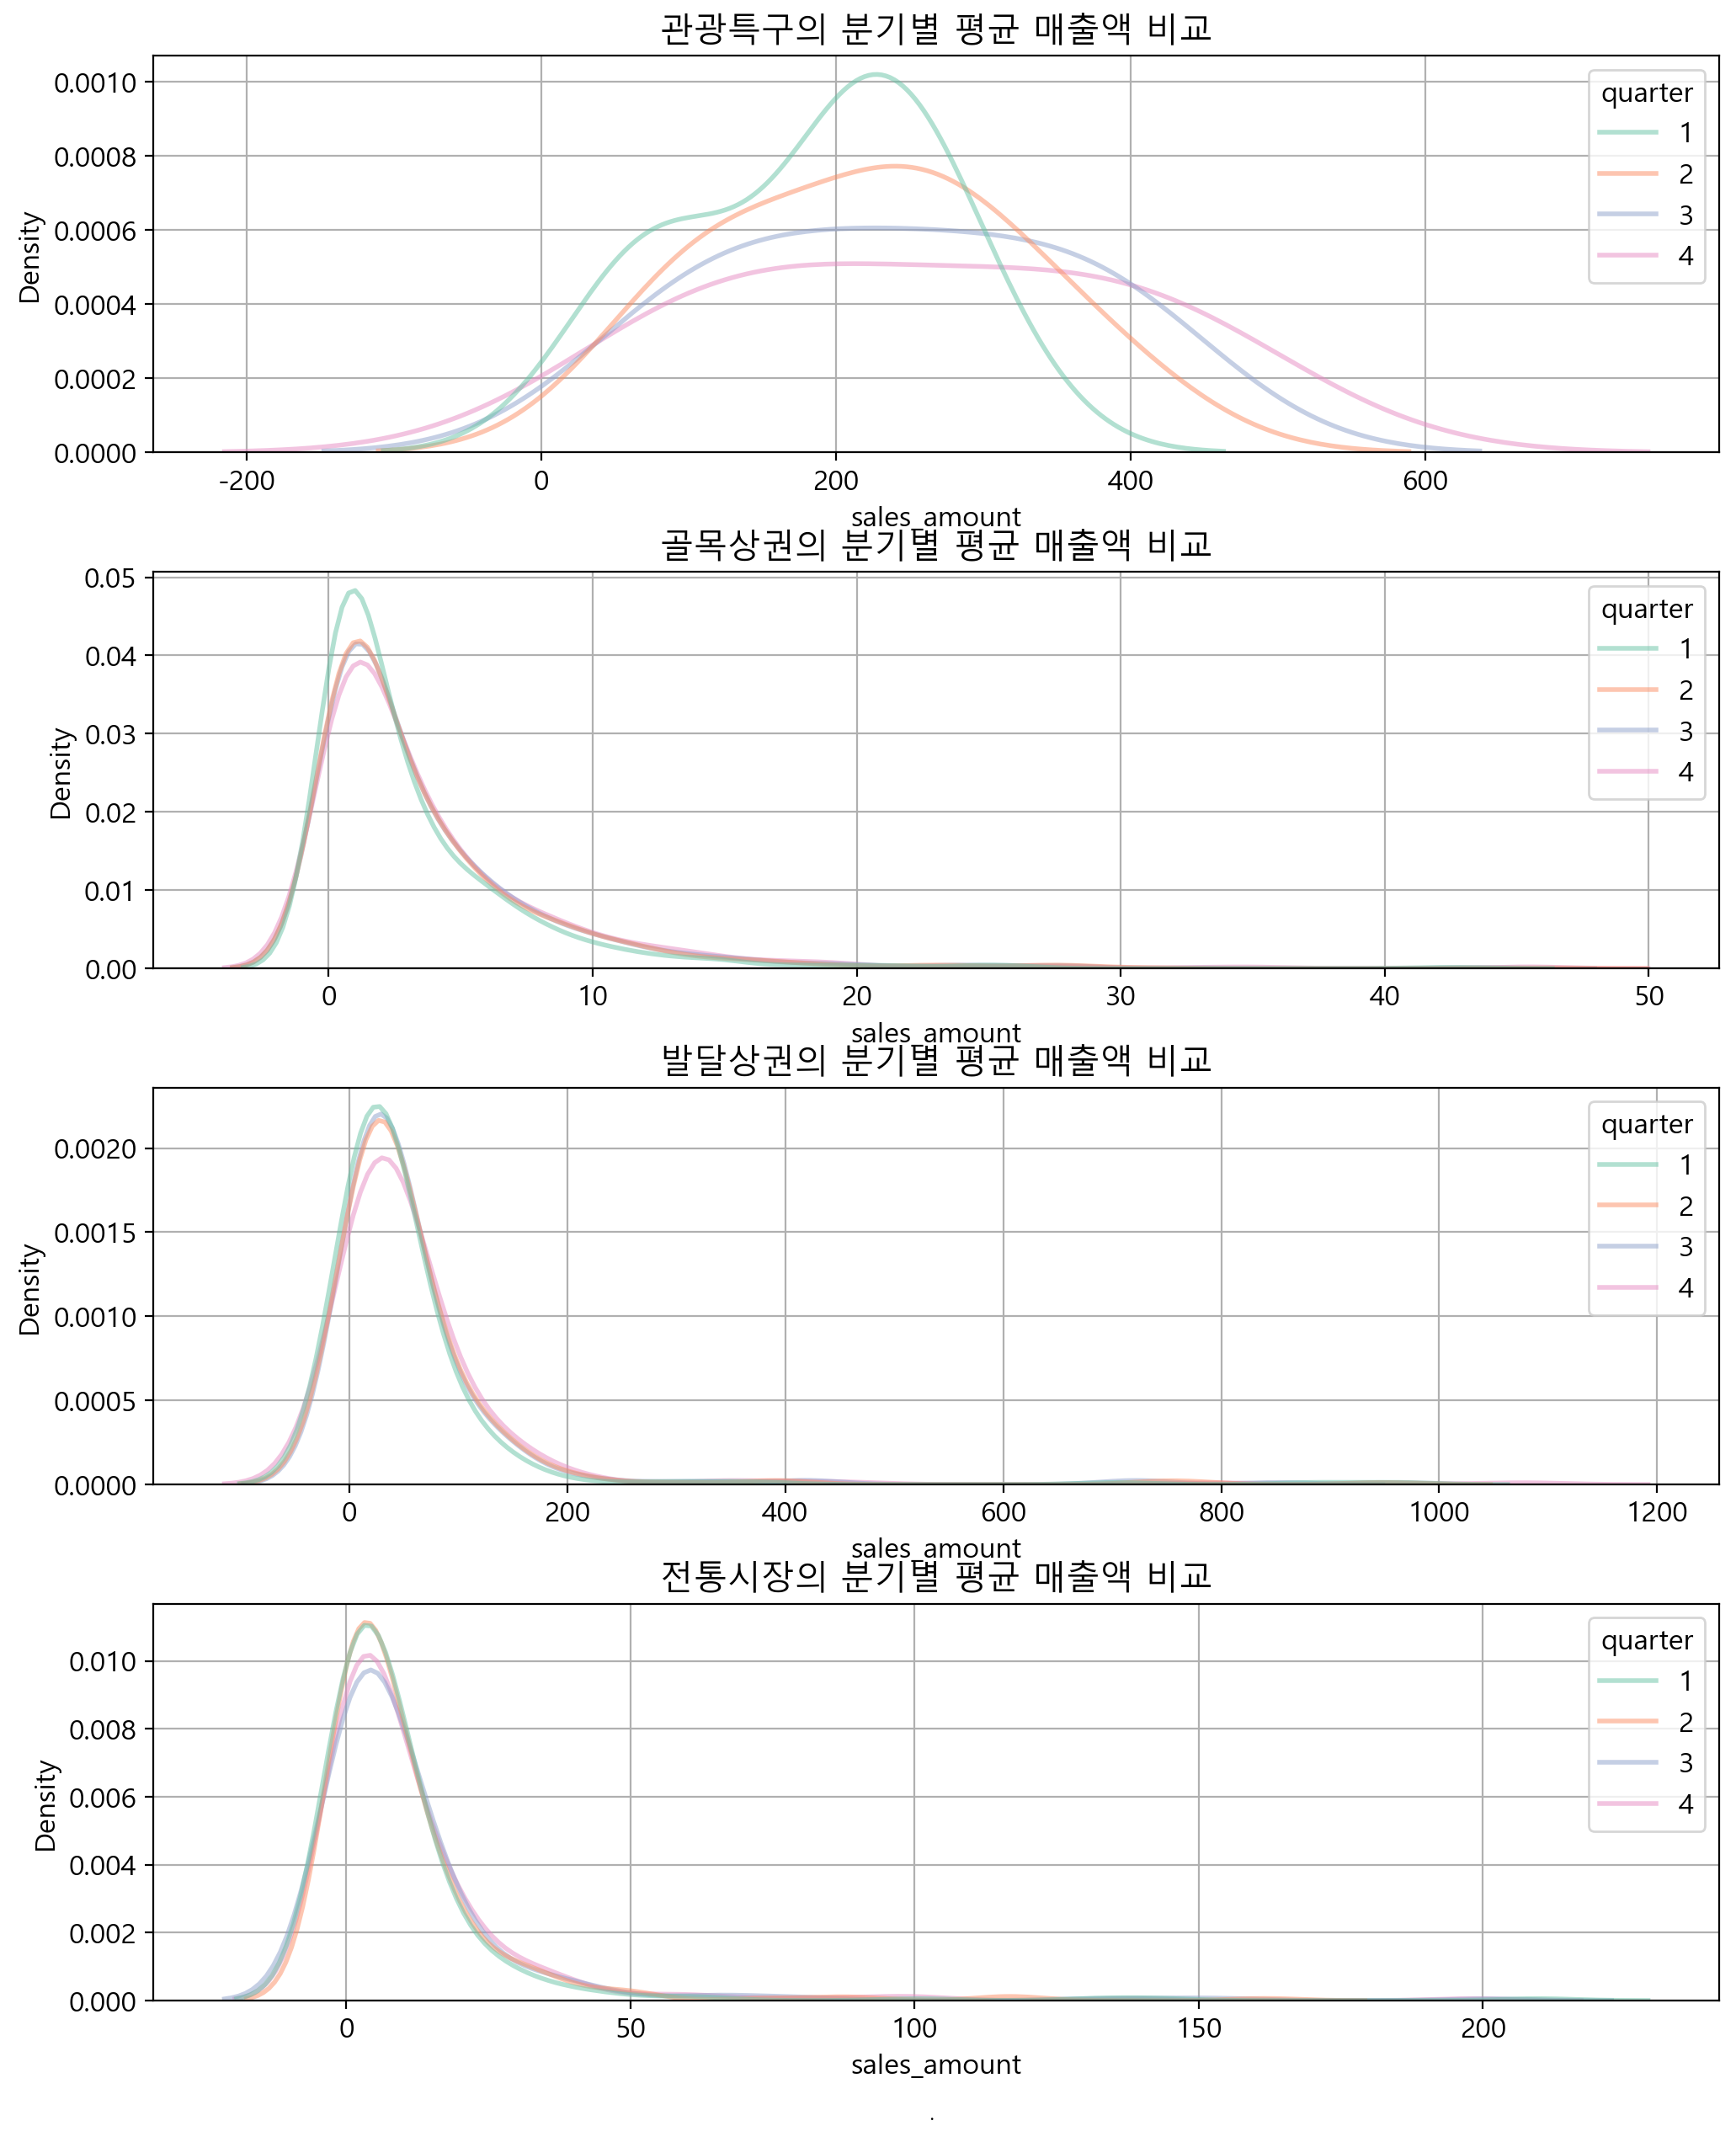

In [47]:
fields = ['관광특구', '골목상권', '발달상권','전통시장']

fig, ax = plt.subplots(4, 1, figsize=(12, 15), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v, in enumerate(ax):
    sb.kdeplot(data=origin[origin['type']==fields[i]], x=origin[origin['type']==fields[i]]['sales_amount'], hue='quarter', palette='Set2',
               fill=False, alpha=.5, linewidth=2, ax=v)
    
    v.grid()
    v.set_title("%s의 분기별 평균 매출액 비교" % fields[i])
    
txt = "."
plt.figtext(0.51, 0.07, txt, wrap=True,
            verticalalignment="top", horizontalalignment="center",
            fontdict={"size": 10, "weight": "light"})

plt.show()
plt.close()

In [ ]:
상권 = origin['type'].unique()
분기 = origin['quarter'].unique()

In [ ]:
for i in 상권:
    for j in 분기:
        data = origin[(origin['type'] == i) & (origin['quarter'] == j)]['sales_amount']
        s, p = shapiro(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p >= 0.05))

[관광특구 + 1] statistic: 0.861, p-value: 0.191, 정규성 충족 여부: True
[관광특구 + 2] statistic: 0.927, p-value: 0.560, 정규성 충족 여부: True
[관광특구 + 3] statistic: 0.872, p-value: 0.236, 정규성 충족 여부: True
[관광특구 + 4] statistic: 0.946, p-value: 0.710, 정규성 충족 여부: True
[골목상권 + 1] statistic: 0.674, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 2] statistic: 0.687, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 3] statistic: 0.696, p-value: 0.000, 정규성 충족 여부: False
[골목상권 + 4] statistic: 0.669, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 1] statistic: 0.375, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 2] statistic: 0.431, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 3] statistic: 0.461, p-value: 0.000, 정규성 충족 여부: False
[발달상권 + 4] statistic: 0.409, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 1] statistic: 0.426, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 2] statistic: 0.537, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 3] statistic: 0.473, p-value: 0.000, 정규성 충족 여부: False
[전통시장 + 4] statistic: 0.522, p-value: 0.000, 정규성 충족 여부: False


In [ ]:
fields = []

for i in 상권:
    for j in 분기:
        data = origin[(origin['type'] == i) & (origin['quarter'] == j)]['sales_amount']
        fields.append(data)

s, p = bartlett(*fields)
print("statistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05))

statistic: 17517.487, p-value: 0.000, 등분산성 충족 여부: False


In [ ]:

formula = 'sales_amount ~ C(quarter)*C(type)'
lm = ols(formula, origin).fit()
anova = anova_lm(lm)
anova

,df,sum_sq,mean_sq,F,PR(>F)
C(quarter),3.0,6.870795e+03,2.290265e+03,1.239640,0.293557
C(type),3.0,3.397628e+06,1.132543e+06,613.005443,0.000000
C(quarter):C(type),9.0,3.140937e+04,3.489930e+03,1.888976,0.048918
Residual,6206.0,1.146574e+07,1.847525e+03,NaN,NaN
